In [42]:
import torch
import os
import json
from torch.nn import CosineSimilarity
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, LlamaForCausalLM, LlamaTokenizer
from functools import partial
from baukit import TraceDict
from einops import rearrange, einsum
from collections import defaultdict
import matplotlib.pyplot as plt
from plotly_utils import imshow, scatter
from tqdm import tqdm
from datasets import Dataset
from torch.utils.data import DataLoader
import math
import seaborn as sns
from peft import PeftModel
import pickle

import pysvelte
import analysis_utils
from counterfactual_datasets.entity_tracking import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(10)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
path = "./llama_7b/"
tokenizer = AutoTokenizer.from_pretrained(path)
model = AutoModelForCausalLM.from_pretrained(path).to(device)

# base_model = "decapoda-research/llama-7b-hf"
# lora_weights = "tiedong/goat-lora-7b"

# tokenizer = LlamaTokenizer.from_pretrained(
#     "hf-internal-testing/llama-tokenizer", padding_side="right"
# )
# model = LlamaForCausalLM.from_pretrained(
#     base_model,
#     load_in_8bit=False,
#     torch_dtype=torch.float32,
#     device_map="auto",
# )
# model = PeftModel.from_pretrained(
#     model,
#     lora_weights,
#     torch_dtype=torch.float32,
#     device_map={"": 0},
# )

tokenizer.pad_token_id = tokenizer.eos_token_id

Loading checkpoint shards: 100%|██████████| 3/3 [00:10<00:00,  3.33s/it]


## Identifying Correct Data

In [3]:
num_boxes = 7
batch_size = 8
data_file_path = f"./box_datasets/no_instructions/alternative/Random/{num_boxes}/train.jsonl"
object_file_path = "./box_datasets/filtered_objects_with_bnc_frequency.csv"

In [5]:
raw_data = entity_tracking_example_sampler(
    tokenizer=tokenizer,
    num_samples=3000,
    data_file=data_file_path,
    alt_examples=True,
    architecture=model.config.architectures[0],
    few_shot=False,
)

In [6]:
raw_dataset = Dataset.from_dict({
    "input_ids": raw_data[0],
    "last_token_ids": raw_data[1],
    "labels": raw_data[2],
}).with_format("torch")

dataloader = DataLoader(raw_dataset, batch_size=batch_size, shuffle=False)

In [7]:
correct_pred_indices = []
for bi, inputs in enumerate(dataloader):
    for k, v in inputs.items():
        if v is not None and isinstance(v, torch.Tensor):
            inputs[k] = v.to(model.device)
    
    output = model(inputs["input_ids"])

    for batch in range(inputs["input_ids"].shape[0]):
        label = inputs["labels"][batch]
        pred = torch.argmax(output.logits[batch, -1], dim=-1)

        if label == pred:
            correct_pred_indices.append(bi * batch_size + batch)

In [10]:
# Store the correct predictions in a json file
with open(f"./box_datasets/no_instructions/alternative/{num_boxes}/correct_prediction_indices.json", "w") as f:
    json.dump(correct_pred_indices, f)


## Load Data

In [4]:
num_boxes = 7
batch_size = 8
data_file_path = f"./box_datasets/no_instructions/alternative/Random/{num_boxes}/train.jsonl"
object_file_path = "./box_datasets/filtered_objects_with_bnc_frequency.csv"

In [5]:
# Load the correct predictions from the json file
with open(f"./box_datasets/no_instructions/alternative/{num_boxes}/correct_prediction_indices.json", "r") as f:
    correct_pred_indices = json.load(f)

In [48]:
def load_data(raw_data, batch_size):

    dataset = Dataset.from_dict(
        {
            "base_input_ids": raw_data[0],
            "base_input_last_pos": raw_data[1],
            "source_input_ids": raw_data[2],
            "source_input_last_pos": raw_data[3],
            "labels": raw_data[4],
        }
    ).with_format("torch")
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
    )

    return dataloader

In [300]:
raw_data = box_label_value_desiderata(
    tokenizer=tokenizer,
    num_samples=500,
    data_file=data_file_path,
    object_file=object_file_path,
    num_boxes=num_boxes,
    alt_format=True,
    correct_pred_indices=[],
)

In [301]:
dataloader = load_data(
    raw_data=raw_data, batch_size=batch_size
)

In [302]:
data = next(enumerate(dataloader))[1]
bi = 3
print(tokenizer.decode(data["base_input_ids"][bi][: data["base_input_last_pos"][bi] + 1]))
print(tokenizer.decode(data["source_input_ids"][bi][: data["source_input_last_pos"][bi] + 1]))
print(tokenizer.decode(data["labels"][bi]))

 The document is in Box X, the pot is in Box T, the magnet is in Box A, the game is in Box E, the bill is in Box M, the cross is in Box K, the map is in Box D. Box E contains the
 The ice is in Box T, the boat is in Box K, the disk is in Box U, the chemical is in Box A, the newspaper is in Box M, the plane is in Box X, the magazine is in Box P. Box X contains the
 document


### Activation Patching

In [303]:
patching_heads = {}
root_path = "./new_pp_exps/reverse/7_boxes"
path = root_path + "/direct_logit_heads.pt"
logit_values = torch.load(path)
direct_logit_heads = analysis_utils.compute_topk_components(torch.load(path), k=35, largest=False)
# patching_heads[0] = direct_logit_heads

path = root_path + "/heads_affect_direct_logit.pt"
logit_values = torch.load(path)
heads_affecting_direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=5, largest=False
)
# patching_heads[0] = heads_affecting_direct_logit_heads

path = root_path + "/heads_at_query_box_pos.pt"
logit_values = torch.load(path)
head_at_query_box_token = analysis_utils.compute_topk_components(
    torch.load(path), k=30, largest=False
)
patching_heads[2] = head_at_query_box_token

path = root_path + "/heads_at_prev_query_box_pos.pt"
logit_values = torch.load(path)
heads_at_prev_box_pos = analysis_utils.compute_topk_components(torch.load(path), k=5, largest=False)

# path = root_path + "/heads_at_next_token_to_prev_box_token.pt"
# logit_values = torch.load(path)
# heads_at_next_token_to_box_pos = analysis_utils.compute_topk_components(
#     torch.load(path), k=5, largest=False
# )

In [304]:
modules = [f"model.layers.{i}.self_attn.o_proj" for i in range(32)]

In [305]:
source_cache = {}
for bi, inputs in enumerate(dataloader):
    for k, v in inputs.items():
        if v is not None and isinstance(v, torch.Tensor):
            inputs[k] = v.to(model.device)
    
    with TraceDict(model, modules, retain_input=True) as cache:
        _ = model(inputs["source_input_ids"])

    for module in modules:
        if bi in source_cache:
            source_cache[bi][module] = cache[module].input.detach().cpu()
        else:
            source_cache[bi] = {module: cache[module].input.detach().cpu()}

In [306]:
def patching(inputs, output, layer, patching_heads, bi):
    if isinstance(inputs, tuple):
        inputs = inputs[0]
    
    inputs = rearrange(inputs, 
                       "batch seq_len (n_heads d_head) -> batch seq_len n_heads d_head",
                       n_heads=model.config.num_attention_heads)
    cache = rearrange(source_cache[bi][layer],
                        "batch seq_len (n_heads d_head) -> batch seq_len n_heads d_head",
                        n_heads=model.config.num_attention_heads)

    for rel_pos in patching_heads.keys():
        layer_index = int(layer.split(".")[2])
        curr_layer_heads = [h for l, h in patching_heads[rel_pos] if l == layer_index]

        pos = inputs.size(1) - rel_pos - 1
        for head in curr_layer_heads:
            inputs[:, pos, head] = cache[:, pos, head]

    inputs = rearrange(inputs,
                        "batch seq_len n_heads d_head -> batch seq_len (n_heads d_head)",
                        n_heads=model.config.num_attention_heads)
    
    w_o = model.state_dict()[f"{layer}.weight"]
    output = einsum(inputs, 
                    w_o, 
                    "batch seq_len hidden_size, d_model hidden_size -> batch seq_len d_model")
    
    del w_o
    torch.cuda.empty_cache()
    return output

In [307]:
correct_count, total_count = 0, 0
for bi, inputs in tqdm(enumerate(dataloader)):
    for k, v in inputs.items():
        if v is not None and isinstance(v, torch.Tensor):
            inputs[k] = v.to(model.device)

    with TraceDict(model, modules, retain_input=True, edit_output=partial(patching, 
                                                                          patching_heads = patching_heads,
                                                                          bi = bi)) as cache:
        outputs = model(inputs["base_input_ids"])

    for idx in range(inputs["base_input_ids"].size(0)):
        label = inputs["labels"][idx].item()
        pred = torch.argmax(outputs.logits[idx, -1], dim=-1).item()

        if label == pred:
            correct_count += 1
        # else:
        #     print(tokenizer.decode(inputs["base_input_ids"][idx][: inputs["base_input_last_pos"][idx] + 1]))
        #     print(tokenizer.decode(pred))
        #     print()
        total_count += 1

    del outputs
    torch.cuda.empty_cache()

print(f"Accuracy: {correct_count / total_count}")

0it [00:00, ?it/s]

63it [00:30,  2.10it/s]

Accuracy: 0.0


In [308]:
semantics['prev_box_attender_heads']['box_label_value'] = correct_count / total_count

In [309]:
semantics

{'value_fetcher_heads': {'positional': 0.066,
  'object_value': 0.322,
  'box_label_value': 0.0},
 'box_attender_heads': {'box_label_value': 0.0,
  'object_value': 0.03,
  'positional': 0.35},
 'prev_box_attender_heads': {'positional': 0.41,
  'object_value': 0.026,
  'box_label_value': 0.0}}

In [201]:
# semantics = {}
# semantics['value_fetcher_heads'] = {}

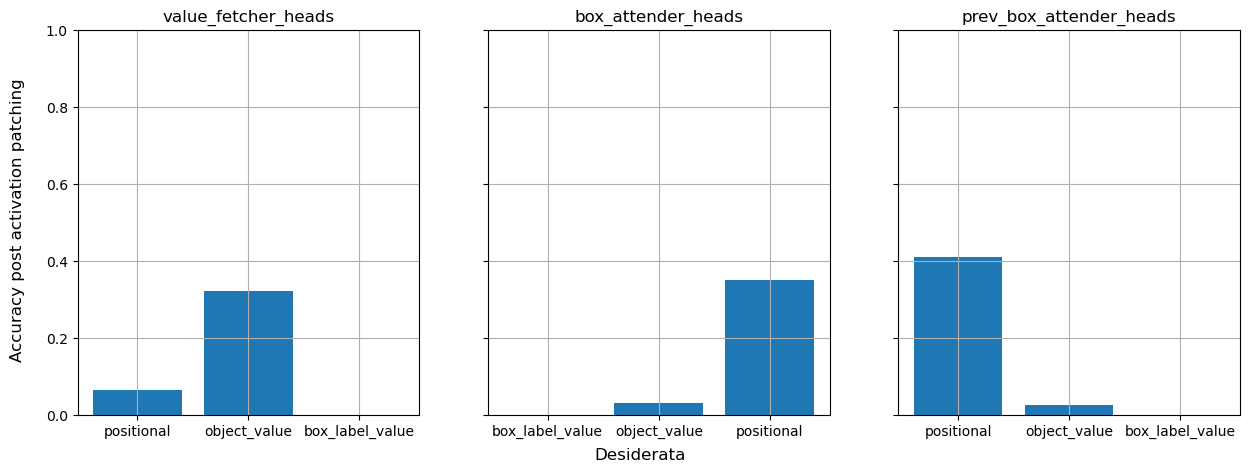

In [321]:
# Plot two subplots for each key in semantics
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for i, key in enumerate(semantics.keys()):
    axs[i].bar(semantics[key].keys(), semantics[key].values())
    axs[i].set_title(key)
    axs[i].set_ylim(0, 1)
    # axs[i].set_ylabel("Accuracy post activation patching")
    # axs[i].set_xlabel("Desiderata")
    axs[i].grid(True)

fig.text(0.08, 0.5, 'Accuracy post activation patching', va='center', rotation='vertical', fontdict={'fontsize': 12})
fig.text(0.5, 0.02, 'Desiderata', ha='center', fontdict={'fontsize': 12})

# fig.tight_layout()
plt.show()